In [1]:
import comp_viz
networks = comp_viz.utils.ObjectDetection.get_networks()
networks.pop(3)
print(networks)

['yolo3_mobilenet1.0_coco', 'ssd_512_resnet50_v1_coco', 'yolo3_darknet53_coco', 'faster_rcnn_fpn_resnet50_v1b_coco', 'faster_rcnn_fpn_syncbn_resnest269_coco']


In [2]:
dataset = { 'person': {"images": 'datasets/person_0/images/', "labels": "datasets/person_0/labelTxt/"} }

In [3]:
import os

test_name = "multi_class"

os.mkdir(f"tests/{test_name}")

for network in networks:
  try:
    os.mkdir(f"tests/{test_name}/{network}")
  except:
    pass

for network in networks:
  try:
    os.mkdir(f"tests/{test_name}/{network}/inference")
  except:
    pass

FileExistsError: [Errno 17] File exists: 'tests/multi_class'

In [4]:
import os
import pathlib
import gluoncv
import json
import numpy as np

raw_fnames = [pathlib.Path(fname).stem for fname in os.listdir(dataset['person']['labels'])]
raw_fnames = [int(val) for val in raw_fnames]
raw_fnames = sorted(raw_fnames)
raw_fnames = [f"{val}.txt" for val in raw_fnames]
gt_paths = [f"datasets/person_0/labelTxt/{val}" for val in raw_fnames]

def generate_paths_list(path):
  raw_fnames = [pathlib.Path(fname).stem for fname in os.listdir(path)]
  raw_fnames = [int(val) for val in raw_fnames]
  raw_fnames = sorted(raw_fnames)
  raw_fnames = [f"{val}.txt" for val in raw_fnames]
  return [os.path.join(path,val) for val in raw_fnames]

def get_gt(fname):
  with open(fname, "r") as f:
    datas = []
    for line in f:
      datas.append(line.strip().split(" "))
  bboxes = []
  for data in datas:
    bbox =  [float(data[0]),
                    float(data[1]),
                    float(data[2]),
                    float(data[5]),
                    int(data[9]),
                    0,
                    0 ]
    bboxes.append(bbox)
  return np.array(bboxes)


def get_inf(fname):
  with open(fname) as f:
    pred = json.load(f)
  bboxes = []
  for i in range(len(pred["bounding_boxes"])):
    bbox = pred["bounding_boxes"][i]
    bbox.append(int(pred["class_ids"][i]))
    bbox.append(float(pred["confidence_scores"][i]))
    bboxes.append(bbox)
  return np.array(bboxes)

In [5]:
test_results = {}
test_results[test_name] = {}

In [6]:
import numpy as np
import pathlib
import json
from mean_average_precision import MetricBuilder
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)



for network in networks:
  model = comp_viz.object_detection.Model(network)
  time = 0
  for image_fname in os.listdir(dataset["person"]["images"]):
    if image_fname in os.listdir(f"tests/{test_name}/{network}/inference/"):
      continue
    pred = model.get_prediction(os.path.join(dataset["person"]["images"],image_fname),nms=.5)
    time += pred["time"]
    with open(f"tests/{test_name}/{network}/inference/{pathlib.Path(image_fname).stem}.txt", "w") as f:
      f.write(json.dumps(pred,indent=2))
  throughput = time / len(os.listdir(dataset["person"]["images"]))
  with open(f"tests/{test_name}/{network}/results.txt", "w") as f:
    f.write(f"Average Seconds Per Image: {np.round(throughput, 4)}")
    f.write("\n")
  metric_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=True, num_classes=1)
  inf_paths = generate_paths_list(f"tests/{test_name}/{network}/inference")
  for i in range(len(os.listdir(dataset['person']['images']))):
    inf_bb = get_inf(inf_paths[i])
    gt_bb = get_gt(gt_paths[i])
    metric_fn.add(inf_bb,gt_bb)
  with open(f"tests/{test_name}/{network}/results.txt", "a") as f:
    f.write(network)
    f.write(str(metric_fn.value(iou_thresholds=0.5)['mAP']))
    f.write("\n")
  print(f"Model: {network}")
  print(f"Precision: {metric_fn.value(iou_thresholds=0.5)['mAP']}")
  print(f"Average time per image: {np.round(throughput, 4)}\n")
  test_results[test_name][network] = { "precision": metric_fn.value(iou_thresholds=0.5)['mAP'] , "time": np.round(throughput, 4) }

[gpu(0)]
Model successfully initialized.


[16:28:43] src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


Model: yolo3_mobilenet1.0_coco
Precision: 0.33279699087142944
Average time per image: 0.1743

[gpu(0)]


/usr/local/lib/python3.8/dist-packages/mxnet/gluon/block.py:1512: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


Model successfully initialized.


[16:29:43] src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


Model: ssd_512_resnet50_v1_coco
Precision: 0.38013359904289246
Average time per image: 0.2334

[gpu(0)]
Model successfully initialized.
Model: yolo3_darknet53_coco
Precision: 0.39821118116378784
Average time per image: 0.236

[gpu(0)]
Model successfully initialized.


[16:32:18] src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


Model: faster_rcnn_fpn_resnet50_v1b_coco
Precision: 0.4614684283733368
Average time per image: 68.4376

[gpu(0)]


/usr/local/lib/python3.8/dist-packages/mxnet/gluon/contrib/nn/basic_layers.py:233: UserWarning: Caution using SyncBatchNorm: if not using all the GPUs, please mannually set num_devices
  warnings.warn("Caution using SyncBatchNorm: "


Model successfully initialized.


[22:15:08] src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


KeyboardInterrupt: 

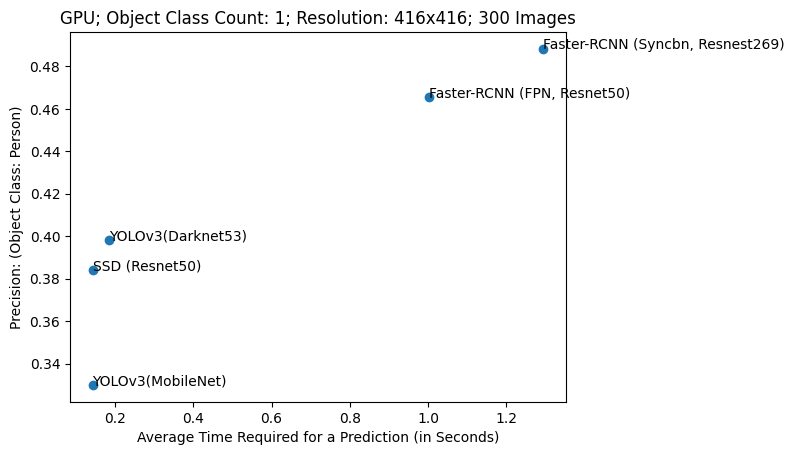

In [23]:
import matplotlib.pyplot as plt
import numpy as np


y = [.33, .3982, .3842, .4654, .4882]
z = [0.1427, 0.1856, .145, 1.0026, 1.2947]
n = ['YOLOv3(MobileNet)', 
     'YOLOv3(Darknet53)',
     'SSD (Resnet50)',
     'Faster-RCNN (FPN, Resnet50)',
     'Faster-RCNN (Syncbn, Resnest269)']

fix, ax = plt.subplots()
ax.scatter(z, y)

plt.title("GPU; Object Class Count: 1; Resolution: 416x416; 300 Images")
plt.ylabel("Precision: (Object Class: Person)")
plt.xlabel("Average Time Required for a Prediction (in Seconds)")

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]))

plt.xticks([val/10 for val in range(0,17)])
plt.yticks([val/100 for val in range(0,70,5)])
    
plt.show()

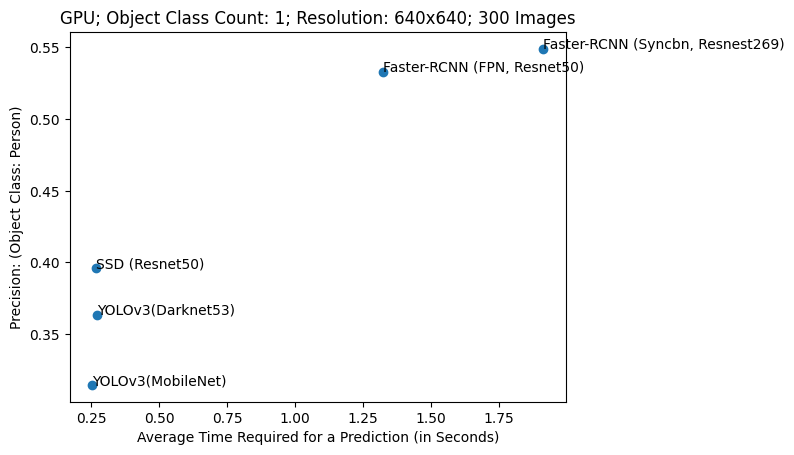

In [8]:
import matplotlib.pyplot as plt
import numpy as np


y = [.31455, .3635, .39622, .5328, .54900]
z = [0.2544, 0.2714, .2657, 1.324, 1.915]

n = ['YOLOv3(MobileNet)', 
     'YOLOv3(Darknet53)',
     'SSD (Resnet50)',
     'Faster-RCNN (FPN, Resnet50)',
     'Faster-RCNN (Syncbn, Resnest269)']

fix, ax = plt.subplots()
ax.scatter(z, y)

plt.title("GPU; Object Class Count: 1; Resolution: 640x640; 300 Images")
plt.ylabel("Precision: (Object Class: Person)")
plt.xlabel("Average Time Required for a Prediction (in Seconds)")

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]))
    
ax.scatter(z,y)

plt.xticks([val/10 for val in range(0,17)])
plt.yticks([val/100 for val in range(0,70,5)])

plt.show()

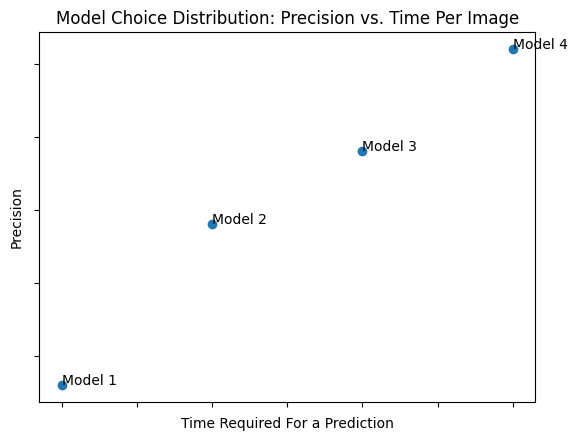

In [11]:
import matplotlib.pyplot as plt
import numpy as np



y = [.33, .44, .49, .56]
z = [0.2, 0.3, 0.4, .5]

n = ['Model 1', 
     'Model 2',
     'Model 3',
     'Model 4']

fix, ax = plt.subplots()
ax.scatter(z, y)

plt.title("Model Choice Distribution: Precision vs. Time Per Image")
plt.ylabel("Precision")
plt.xlabel("Time Required For a Prediction")


for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]))

ax.set_yticklabels([])
ax.set_xticklabels([])

    
plt.show()

In [ ]:
print("HI")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


y = [.3327, .3982, .3801, .4654, .4882]
z = [0.1743, 0.236, .2234, 1.0026, 1.2947]
n = ['YOLOv3(MobileNet)', 
     'YOLOv3(Darknet53)',
     'SSD (Resnet50)',
     'Faster-RCNN (FPN, Resnet50)',
     'Faster-RCNN (Syncbn, Resnest269)']

fix, ax = plt.subplots()
ax.scatter(z, y)

plt.title("GPU; Object Class Count: Multi; Resolution: 416x416; 300 Images")
plt.ylabel("Precision: (Object Class: Person)")
plt.xlabel("Average Time Required for a Prediction (in Seconds)")

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]))

plt.xticks([val/10 for val in range(0,17)])
plt.yticks([val/100 for val in range(0,70,5)])
    
plt.show()

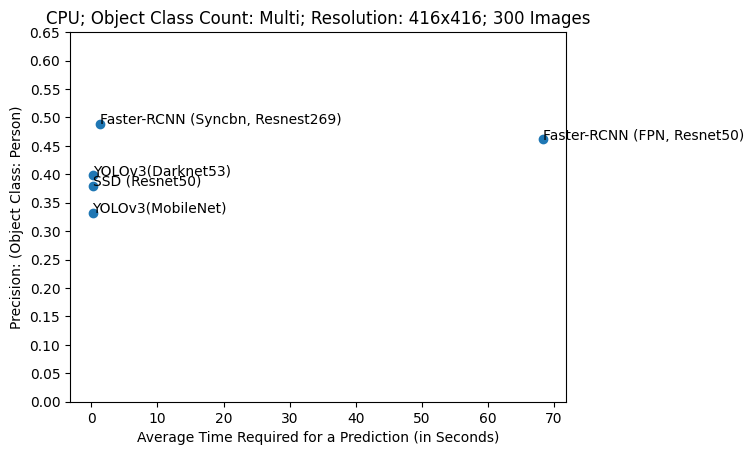

In [8]:
import matplotlib.pyplot as plt
import numpy as np


y = [.3327, .3982, .3801, .4614, .4882]
z = [0.1743, 0.236, .2234, 68.4376, 1.2947]
n = ['YOLOv3(MobileNet)', 
     'YOLOv3(Darknet53)',
     'SSD (Resnet50)',
     'Faster-RCNN (FPN, Resnet50)',
     'Faster-RCNN (Syncbn, Resnest269)']

fix, ax = plt.subplots()
ax.scatter(z, y)

plt.title("CPU; Object Class Count: Multi; Resolution: 416x416; 300 Images")
plt.ylabel("Precision: (Object Class: Person)")
plt.xlabel("Average Time Required for a Prediction (in Seconds)")

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]))

plt.yticks([val/100 for val in range(0,70,5)])
    
plt.show()